# Matching Phase Igual do Artigo do Hugo
Casamento de fase da biblioteca diretamente com os mapas de fase.

## Bibliotecas

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

import time
from tqdm import tqdm

from scipy.fft import fft2, ifft2, fftshift, ifftshift
from PIL import Image

## Carregar Bibliotecas

Carrega as bibliotecas, filtra a altura para 600 nm e rotação igual a 0 graus, e cria um dataframe.

In [14]:
caminho_real_pkl = "/content/7lib.pkl"

try:
    df_real = pd.read_pickle(caminho_real_pkl)
    print(f"Biblioteca real carregada. Forma: {df_real.shape}")

    if 'S24_real' not in df_real.columns or 'S13_real' not in df_real.columns:
        raise KeyError("Colunas 'S24_real' ou 'S13_real' não encontradas no .pkl")

    df_real['S_complex_TM'] = df_real['S24_real'] + 1j * df_real['S24_imag']
    df_real['S_complex_TE'] = df_real['S13_real'] + 1j * df_real['S13_imag']

    print("Colunas 'S_complex_TM' (S24) e 'S_complex_TE' (S13) criadas com sucesso.")

    DEFAULT_HEIGHT = 600.0
    DEFAULT_ANGLE = 0.0

    df_filtrado_2D = df_real[
        (df_real['H'] == DEFAULT_HEIGHT) &
        (df_real['a'] == DEFAULT_ANGLE)
    ].copy()

    print(f"Biblioteca filtrada para 2D (H={DEFAULT_HEIGHT}, a={DEFAULT_ANGLE}). Nova forma: {df_filtrado_2D.shape}")

    if df_filtrado_2D.shape[0] == 0:
        raise ValueError("Filtragem resultou em 0 átomos. Verifique os valores DEFAULT_HEIGHT/ANGLE.")

    #Mudamos as colunas para os nomes que a NN trabalha
    df_filtrado_2D['Transmitancia_x'] = np.abs(df_filtrado_2D['S_complex_TM'])
    df_filtrado_2D['Fase_x'] = np.angle(df_filtrado_2D['S_complex_TM'])

    df_filtrado_2D['Transmitancia_y'] = np.abs(df_filtrado_2D['S_complex_TE'])
    df_filtrado_2D['Fase_y'] = np.angle(df_filtrado_2D['S_complex_TE'])
    df = df_filtrado_2D

    print("\n--- Preparação de Dados Concluída ---")
    print("DataFrame 'df' está pronto para ser usado pela rede neural.")
    print(df[['L_x', 'L_y', 'Transmitancia_x', 'Fase_x', 'Transmitancia_y', 'Fase_y']].head())

except FileNotFoundError:
    print(f"\n--- ERRO: Arquivo NÃO encontrado ---")
    print(f"Verifique o caminho: '{caminho_real_pkl}'")
except KeyError as e:
    print(f"\n--- ERRO: Coluna não encontrada ---")
    print(f"Ocorreu um erro de chave: {e}.")
    print("Verifique se as colunas (ex: 'S24_real' ou 'S13_real') existem no .pkl.")
except Exception as e:
    print(f"Ocorreu um erro inesperado: {e}")

Biblioteca real carregada. Forma: (5507, 54)
Colunas 'S_complex_TM' (S24) e 'S_complex_TE' (S13) criadas com sucesso.
Biblioteca filtrada para 2D (H=600.0, a=0.0). Nova forma: (2371, 56)

--- Preparação de Dados Concluída ---
DataFrame 'df' está pronto para ser usado pela rede neural.
      L_x   L_y  Transmitancia_x    Fase_x  Transmitancia_y    Fase_y
30   70.0  70.0         0.988019 -1.310207         0.988251 -1.310759
81   70.0  75.0         0.988320 -1.328479         0.989054 -1.359100
132  70.0  80.0         0.989101 -1.343390         0.990052 -1.411462
183  70.0  85.0         0.989206 -1.361828         0.991399 -1.474434
234  70.0  90.0         0.989365 -1.379114         0.993022 -1.546775


# Mapas de Fase

Criação do mapa de fase para a polarização x:

In [15]:
def load_and_preprocess_image(image_path, target_size=(90, 90)):
    """
    Carrega e pré-processa a imagem alvo usando PIL
    """
    try:
        image = Image.open(image_path).convert('L')
        image = image.resize(target_size, Image.LANCZOS)
        image_array = np.array(image, dtype=np.float64)
        image_array = image_array / np.max(image_array)
        return image_array
    except FileNotFoundError:
        print(f"Atenção: Imagem '{image_path}' não encontrada. Criando imagem de teste...")
        target_image = np.zeros(target_size)
        target_image[150:300, 100:200] = 1.0
        target_image[150:200, 200:350] = 1.0
        target_image[250:300, 200:350] = 1.0
        return target_image

def apply_zero_padding(image, padding_factor=2):
    """
    Aplica zero-padding à imagem
    """
    original_size = image.shape
    padded_size = (image.shape[0] * padding_factor, image.shape[1] * padding_factor)
    padded_image = np.zeros(padded_size, dtype=complex)

    start_row = (padded_size[0] - original_size[0]) // 2
    start_col = (padded_size[1] - original_size[1]) // 2
    padded_image[start_row:start_row+original_size[0],
                 start_col:start_col+original_size[1]] = image

    return padded_image, original_size

def create_low_pass_filter(shape, wavelength, dx, NA):
    """
    Cria filtro passa-baixa baseado na abertura numérica
    """
    nx, ny = shape
    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    f_cutoff = NA / wavelength
    freq_radius = np.sqrt(FX**2 + FY**2)
    filter_mask = (freq_radius <= f_cutoff).astype(np.float64)

    return filter_mask

def angular_spectrum_propagation(U, wavelength, z, dx, filter_mask=None):
    """
    Propaga o campo usando método do espectro angular
    """
    k = 2 * np.pi / wavelength
    nx, ny = U.shape

    fx = np.fft.fftfreq(nx, dx)
    fy = np.fft.fftfreq(ny, dx)
    FX, FY = np.meshgrid(fx, fy, indexing='ij')

    root_term = 1 - (wavelength * FX)**2 - (wavelength * FY)**2
    root_term[root_term < 0] = 0

    H = np.exp(1j * k * z * np.sqrt(root_term))

    if filter_mask is not None:
        H = H * filter_mask

    U_freq = fft2(U)
    U_prop_freq = U_freq * H
    U_prop = ifft2(U_prop_freq)

    return U_prop

def calculate_correlation(target, reconstructed):
    """
    Calcula a correlação de Pearson entre duas imagens (valores reais)
    """
    target_real = np.real(target).flatten()
    reconstructed_real = np.real(reconstructed).flatten()

    correlation = np.corrcoef(target_real, reconstructed_real)[0, 1]

    if np.isnan(correlation):
        return 0.0

    return float(correlation)

def extract_center(image, original_size):
    """
    Extrai região central da imagem (remove padding)
    """
    nx, ny = original_size
    start_row = (image.shape[0] - nx) // 2
    start_col = (image.shape[1] - ny) // 2
    return image[start_row:start_row+nx, start_col:start_col+ny]

def reconstruct_image(phase_map, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir do mapa de fase
    """
    # Aplica zero-padding ao mapa de fase
    phase_padded, original_size = apply_zero_padding(np.exp(1j * phase_map))

    # Cria filtro
    filter_mask = create_low_pass_filter(phase_padded.shape, wavelength, dx, NA)

    # Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(phase_padded, wavelength, z, dx, filter_mask)

    # Extrai região central e pega a amplitude (np.abs)
    reconstructed = extract_center(np.abs(reconstructed), original_size)

    return np.real(reconstructed)  # Garante valor real

def reconstruct_image_from_field(complex_field, wavelength, z, dx, NA):
    """
    Reconstrói a imagem a partir de um CAMPO COMPLEXO (Amp + Fase)
    Isso é mais preciso, pois leva em conta a eficiência de cada meta-átomo.
    """
    # 1. Aplica zero-padding ao campo complexo
    field_padded, original_size = apply_zero_padding(complex_field)

    # 2. Cria filtro
    filter_mask = create_low_pass_filter(field_padded.shape, wavelength, dx, NA)

    # 3. Propaga para o plano da imagem
    reconstructed = angular_spectrum_propagation(field_padded, wavelength, z, dx, filter_mask)

    # 4. Extrai região central e pega a amplitude (np.abs)
    reconstructed_center = extract_center(reconstructed, original_size)
    reconstructed_amplitude = np.abs(reconstructed_center)

    return np.real(reconstructed_amplitude) # Garante valor real

def gerchberg_saxton_angular_spectrum(target, wavelength, z, dx, NA, num_iter=50):
    """
    Algoritmo de Gerchberg-Saxton com espectro angular
    Retornar a imagem original e a reconstruída
    """
    target_padded, original_size = apply_zero_padding(target)
    nx_pad, ny_pad = target_padded.shape

    filter_mask = create_low_pass_filter((nx_pad, ny_pad), wavelength, dx, NA)

    phase = np.random.rand(nx_pad, ny_pad) * 2 * np.pi
    U = target_padded * np.exp(1j * phase)

    correlations = []

    for i in range(num_iter):
        # 1. Propaga para o plano da imagem
        U_image = angular_spectrum_propagation(U, wavelength, z, dx, filter_mask)

        # 2. Mantém a fase, atualiza amplitude com alvo
        amplitude_image = np.abs(U_image)
        phase_image = np.angle(U_image)

        # Calcula correlação para monitorar convergência
        target_region = extract_center(target_padded, original_size)
        recon_region = extract_center(amplitude_image, original_size)

        corr = calculate_correlation(target_region, recon_region)
        correlations.append(corr)

        # Atualiza campo no plano da imagem
        U_image_updated = target_padded * np.exp(1j * phase_image)

        # 3. Propaga de volta para o plano do holograma
        U = angular_spectrum_propagation(U_image_updated, wavelength, -z, dx, filter_mask)

        # 4. Mantém a fase, atualiza amplitude com incidente (unitária)
        phase_hologram = np.angle(U)
        U = np.exp(1j * phase_hologram) # Amplitude unitária (holograma de fase)

        if (i + 1) % 10 == 0:
            print(f" 	Iteração GS (X) {i+1}/{num_iter}, Correlação: {corr:.4f}")

    phase_final = extract_center(np.angle(U), original_size)

    reconstructed_image = reconstruct_image(phase_final, wavelength, z, dx, NA)

    return target, reconstructed_image, phase_final, correlations

Carregando e pré-processando imagem...
Executando algoritmo de Gerchberg-Saxton...
 	Iteração GS (X) 10/200, Correlação: 0.9586
 	Iteração GS (X) 20/200, Correlação: 0.9688
 	Iteração GS (X) 30/200, Correlação: 0.9723
 	Iteração GS (X) 40/200, Correlação: 0.9730
 	Iteração GS (X) 50/200, Correlação: 0.9731
 	Iteração GS (X) 60/200, Correlação: 0.9730
 	Iteração GS (X) 70/200, Correlação: 0.9731
 	Iteração GS (X) 80/200, Correlação: 0.9738
 	Iteração GS (X) 90/200, Correlação: 0.9740
 	Iteração GS (X) 100/200, Correlação: 0.9738
 	Iteração GS (X) 110/200, Correlação: 0.9740
 	Iteração GS (X) 120/200, Correlação: 0.9744
 	Iteração GS (X) 130/200, Correlação: 0.9746
 	Iteração GS (X) 140/200, Correlação: 0.9746
 	Iteração GS (X) 150/200, Correlação: 0.9747
 	Iteração GS (X) 160/200, Correlação: 0.9746
 	Iteração GS (X) 170/200, Correlação: 0.9751
 	Iteração GS (X) 180/200, Correlação: 0.9752
 	Iteração GS (X) 190/200, Correlação: 0.9750
 	Iteração GS (X) 200/200, Correlação: 0.9749

Corre

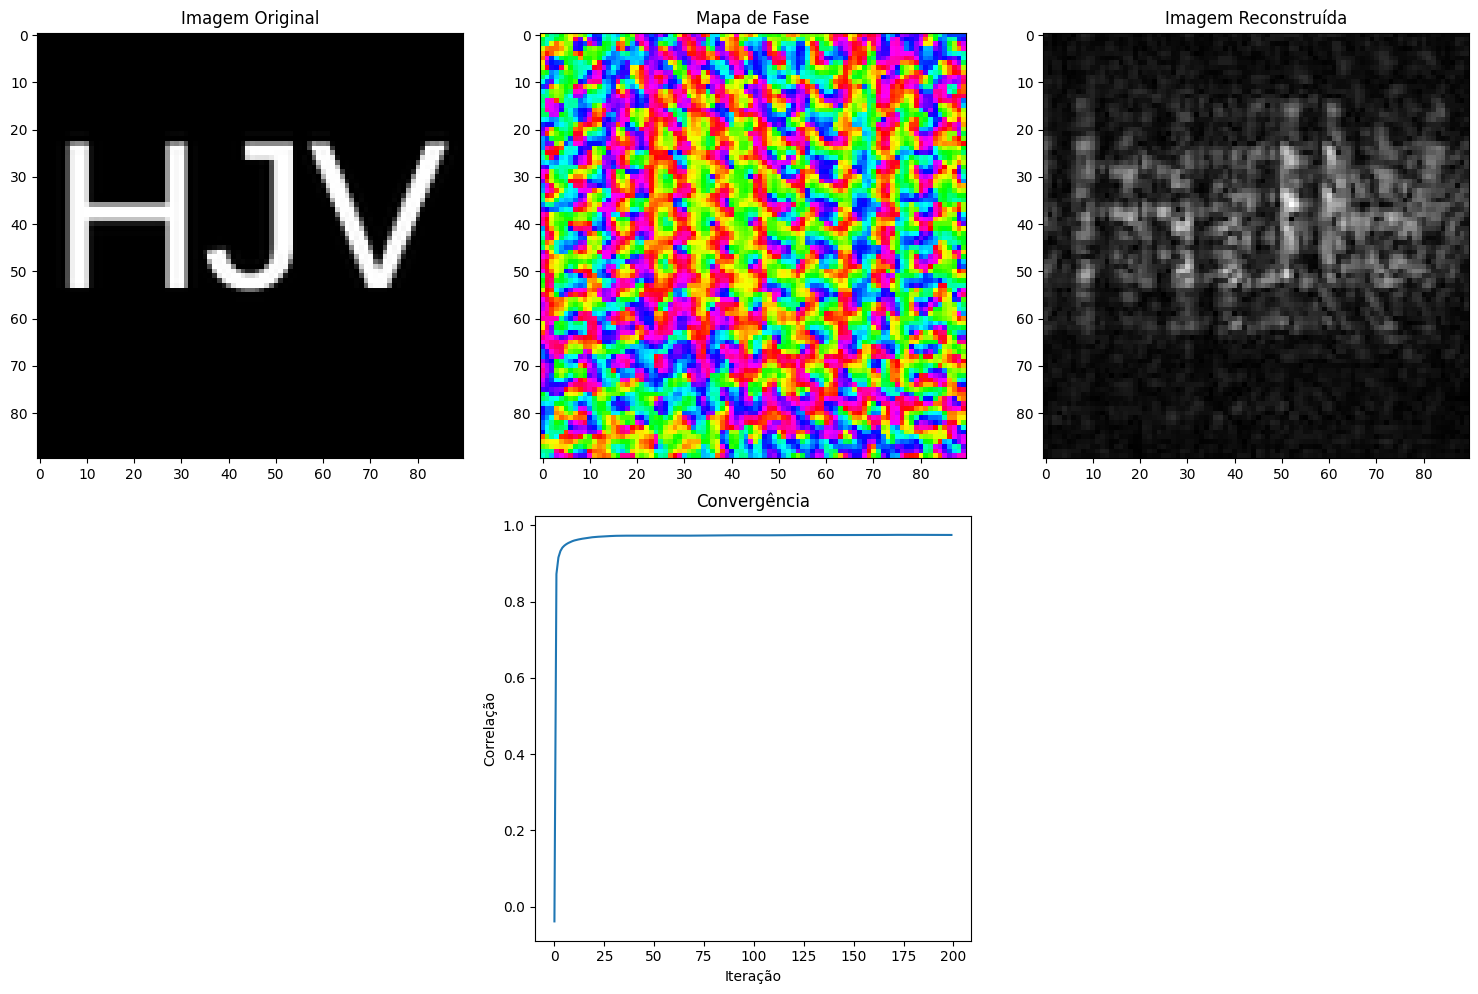

In [16]:
wavelength = 1064e-9  # 1064 nm
z = 380e-6           # 380 μm
dx = 520e-9          # pixel pitch
NA = 0.65            # abertura numérica
num_iter = 200       # número de iterações

print("Carregando e pré-processando imagem...")
target_original = load_and_preprocess_image('/content/HJV.png', target_size=(90, 90))

print("Executando algoritmo de Gerchberg-Saxton...")

img_original, img_reconstruida, mapa_de_fase, correlations = gerchberg_saxton_angular_spectrum(
    target_original,
    wavelength,
    z,
    dx,
    NA,
    num_iter
)
print(f"\nCorrelação final: {correlations[-1]:.4f}")

print(f"Dimensões da Imagem Original: {img_original.shape}")
print(f"Dimensões da Imagem Reconstruída: {img_reconstruida.shape}")
print(f"Dimensões do Mapa de Fase: {mapa_de_fase.shape}")

# np.savetxt('phase_map_x_polarization.txt', mapa_de_fase)
# np.savetxt('correlations.txt', correlations)

plt.figure(figsize=(15, 10))

plt.subplot(2, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title('Imagem Original')

plt.subplot(2, 3, 2)
plt.imshow(mapa_de_fase, cmap='hsv')
plt.title('Mapa de Fase')

plt.subplot(2, 3, 3)
plt.imshow(img_reconstruida, cmap='gray')
plt.title('Imagem Reconstruída')

plt.subplot(2, 3, 5)
plt.plot(correlations)
plt.title('Convergência')
plt.xlabel('Iteração')
plt.ylabel('Correlação')

plt.tight_layout()
plt.show()

## Polarização y:

In [17]:
def generate_dammann_phase_map(
    P: float = 520e-9,
    wavelength: float = 1064e-9,
    supercell_pixels: int = 45,
    n_supercells: int = 10,
    iters_gs: int = 400,
    random_seed: int = 0,
    verbose: bool = True
) -> tuple[np.ndarray, dict, list]:
    """
    Gera o mapa de fase para uma grade de Dammann (spot-cloud) usando o algoritmo GS.
    """
    np.random.seed(random_seed)

    N_super = supercell_pixels
    dx = P
    d = dx * N_super

    # --- Grade k e alvo ---
    # (Esta função usa np.fft, o que não conflita com o Bloco 1)
    kx = np.fft.fftfreq(N_super, d=dx)
    ky = np.fft.fftfreq(N_super, d=dx)
    kx_shift = np.fft.fftshift(kx)
    ky_shift = np.fft.fftshift(ky)
    KX, KY = np.meshgrid(kx_shift, ky_shift)
    K_rad = np.sqrt(KX**2 + KY**2)
    target_radius = min(1.0 / wavelength, 1.0 / (2.0 * dx))
    target_amp = (K_rad <= target_radius).astype(float)

    # --- Algoritmo GS ---
    plane_field = np.exp(1j * 2.0 * np.pi * np.random.rand(N_super, N_super))
    errors = []

    # Loop de iteração para Dammann
    gs_iterator = range(iters_gs)
    if verbose:
        # Cria uma barra de progresso se 'verbose' for True
        gs_iterator = tqdm(range(iters_gs), desc="  Iterações GS (Y)", leave=False)

    for it in gs_iterator:
        far = np.fft.fft2(plane_field)
        far_shift = np.fft.fftshift(far)

        amp_current = np.abs(far_shift)
        err = np.sqrt(np.mean((amp_current / (amp_current.max() + 1e-9) - target_amp)**2))
        errors.append(err)

        far_shift = target_amp * np.exp(1j * np.angle(far_shift))
        far = np.fft.ifftshift(far_shift)

        plane_field = np.fft.ifft2(far)
        plane_field = np.exp(1j * np.angle(plane_field))

    supercell_phase = np.angle(plane_field)

    # --- Construção da Metassuperfície Completa ---
    full_phase = np.tile(supercell_phase, (n_supercells, n_supercells))

    if verbose:
        print(f"  Mapa Dammann (Y) gerado: {full_phase.shape} pixels")

    metrics = {} # Vazio, focado apenas na geração de fase

    return full_phase, metrics, errors


Iniciando Geração de Fase...


  Mapa Dammann (Y) gerado: (90, 90) pixels
Geração de Fase Concluída.
Iniciando análise e plotagem...
Plot 1: Gerando plot_mapa_fase.png...
Plot 2: Gerando plot_erro_gs.png...
Análise: Calculando Far-Field da metassuperfície completa...
Análise: Extraindo ordens de difração...
Análise concluída. Encontradas 1513 ordens propagantes.
Plot 3: Gerando plot_far_field.png...
Plot 4: Gerando plot_ordens_scatter.png...

Todos os plots foram salvos como arquivos .png.

--- Resumo das Ordens ---
    p  q     intensity            k_p            k_q
0 -21 -6  48415.277409 -897435.897436 -256410.256410
1 -21 -5  44099.576047 -897435.897436 -213675.213675
2 -21 -4  47457.195916 -897435.897436 -170940.170940
3 -21 -3  41993.310106 -897435.897436 -128205.128205
4 -21 -2  38967.541269 -897435.897436  -85470.085470


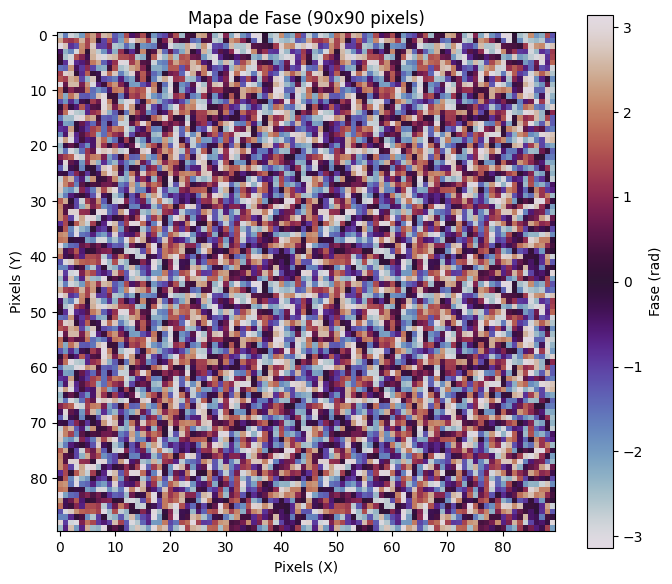

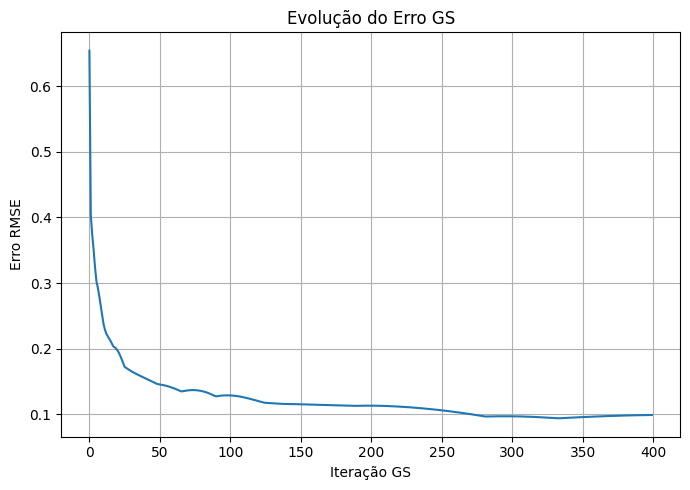

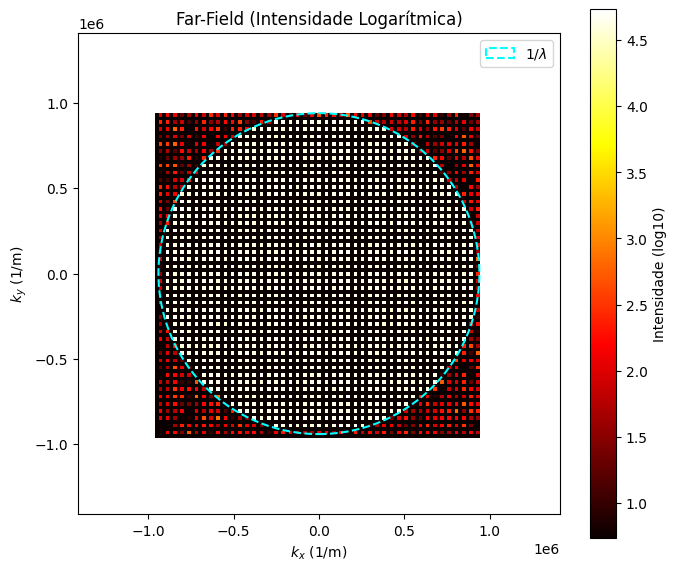

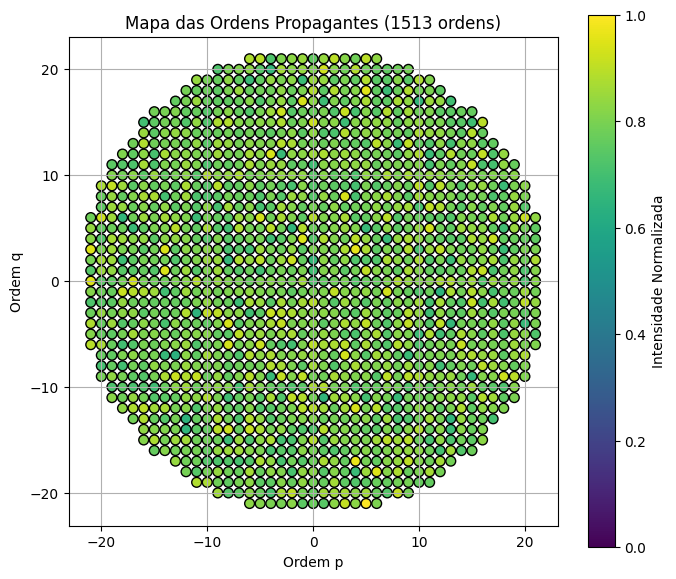

In [18]:
def analyze_and_plot_results(
    full_phase: np.ndarray,
    errors: list,
    P: float,
    wavelength: float,
    supercell_pixels: int
) -> pd.DataFrame:
    """
    Analisa e plota os resultados da metassuperfície.

    Esta função calcula o far-field, analisa as ordens de difração e
    gera os 4 plots principais (Mapa de Fase, Erro GS, Far-Field, Ordens).

    Retorna um DataFrame com os dados das ordens propagantes.
    """

    print("Iniciando análise e plotagem...")

    # --- Plot 1: Mapa de Fase ---
    print("Plot 1: Gerando plot_mapa_fase.png...")
    plt.figure(figsize=(7, 6))
    plt.imshow(full_phase, cmap='twilight', extent=None)
    plt.colorbar(label="Fase (rad)")
    plt.title(f"Mapa de Fase ({full_phase.shape[0]}x{full_phase.shape[1]} pixels)")
    plt.xlabel("Pixels (X)")
    plt.ylabel("Pixels (Y)")
    plt.tight_layout()
    plt.savefig("plot_mapa_fase.png", dpi=150)

    # --- Plot 2: Evolução do Erro ---
    print("Plot 2: Gerando plot_erro_gs.png...")
    plt.figure(figsize=(7, 5))
    plt.plot(errors)
    plt.xlabel("Iteração GS")
    plt.ylabel("Erro RMSE")
    plt.title("Evolução do Erro GS")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig("plot_erro_gs.png", dpi=150)

    # --- Análise de Far-Field (Células 8 & 9) ---
    print("Análise: Calculando Far-Field da metassuperfície completa...")
    N_full = full_phase.shape[0]
    dx_full = P

    # Criar a grade k
    kx_full = np.fft.fftfreq(N_full, d=dx_full)
    ky_full = np.fft.fftfreq(N_full, d=dx_full)
    kx_full_shift = np.fft.fftshift(kx_full)
    ky_full_shift = np.fft.fftshift(ky_full)

    # Calcular o far-field
    plane_field_full = np.exp(1j * full_phase)
    far_field_full = np.fft.fft2(plane_field_full)
    far_field_full_shift = np.fft.fftshift(far_field_full)
    far_field_intensity = np.abs(far_field_full_shift)**2

    print("Análise: Extraindo ordens de difração...")
    d_supercell = supercell_pixels * P
    max_order = int(np.floor((d_supercell) / wavelength))

    p_range = np.arange(-max_order, max_order + 1)
    q_range = np.arange(-max_order, max_order + 1)
    order_data = []

    for p in p_range:
        for q in q_range:
            k_p = p / d_supercell
            k_q = q / d_supercell

            idx_p = np.argmin(np.abs(kx_full_shift - k_p))
            idx_q = np.argmin(np.abs(ky_full_shift - k_q))

            k_rad_order = np.sqrt(k_p**2 + k_q**2)
            if k_rad_order <= (1.0 / wavelength):
                intensity = far_field_intensity[idx_q, idx_p]
                order_data.append({'p': p, 'q': q, 'intensity': intensity, 'k_p': k_p, 'k_q': k_q})

    df_orders = pd.DataFrame(order_data)
    print(f"Análise concluída. Encontradas {len(df_orders)} ordens propagantes.")

    print("Plot 3: Gerando plot_far_field.png...")
    log_intensity = np.log10(far_field_intensity + 1e-9)
    vmax_val = log_intensity.max()
    vmin_val = vmax_val - 4

    plt.figure(figsize=(7, 6))
    plt.imshow(
        log_intensity,
        cmap='hot',
        extent=[kx_full_shift.min(), kx_full_shift.max(), ky_full_shift.min(), ky_full_shift.max()],
        vmin=vmin_val,
        vmax=vmax_val,
        origin='lower'
    )

    k_max_plot = 1.0 / wavelength
    circle = plt.Circle((0, 0), k_max_plot, color='cyan', fill=False, linestyle='--', linewidth=1.5, label=r'$1/\lambda$')
    plt.gca().add_artist(circle)
    plt.legend(handles=[circle])

    plt.xlim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.ylim(-k_max_plot * 1.5, k_max_plot * 1.5)
    plt.colorbar(label="Intensidade (log10)")
    plt.title("Far-Field (Intensidade Logarítmica)")
    plt.xlabel(r"$k_x$ (1/m)")
    plt.ylabel(r"$k_y$ (1/m)")
    plt.gca().set_aspect('equal')
    plt.tight_layout()
    plt.savefig("plot_far_field.png", dpi=150)

    print("Plot 4: Gerando plot_ordens_scatter.png...")
    if not df_orders.empty:
        plt.figure(figsize=(7, 6))
        norm_intensity = df_orders['intensity'] / (df_orders['intensity'].max() + 1e-9)

        sc = plt.scatter(df_orders['p'], df_orders['q'], c=norm_intensity, cmap='viridis', s=50, edgecolor="k", vmin=0)
        plt.colorbar(sc, label="Intensidade Normalizada")
        plt.xlabel("Ordem p")
        plt.ylabel("Ordem q")
        plt.title(f"Mapa das Ordens Propagantes ({len(df_orders)} ordens)")
        plt.grid(True)
        plt.gca().set_aspect('equal')
        plt.tight_layout()
        plt.savefig("plot_ordens_scatter.png", dpi=150)
    else:
        print("Plot 4: DataFrame de ordens vazio, pulando o scatter plot.")

    print("\nTodos os plots foram salvos como arquivos .png.")

    return df_orders

P = 520e-9
wavelength = 1064e-9
supercell_pixels = 45
n_supercells = 2
iters_gs = 400
random_seed = 0

print("Iniciando Geração de Fase...")
full_phase, _, errors = generate_dammann_phase_map(
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels,
    n_supercells=n_supercells,
    iters_gs=iters_gs,
    random_seed=random_seed,
    verbose=True
)
print("Geração de Fase Concluída.")

df_ordens_propagantes = analyze_and_plot_results(
    full_phase=full_phase,
    errors=errors,
    P=P,
    wavelength=wavelength,
    supercell_pixels=supercell_pixels
)

print("\n--- Resumo das Ordens ---")
print(df_ordens_propagantes.head())

# Matching Phase

Aplicar a mesma lógica do artigo do Hugo.

$min[ (E_{xx} - e^{i*\phi_{xx}}) + (E_{yy} - e^{i*\phi_{yy}}) ]$

In [19]:
print(f"Iniciando casamento de fase para mapas {mapa_de_fase.shape}...")

N_rows, N_cols = mapa_de_fase.shape

# --- Inicialize TODOS os mapas que queremos salvar ---
mapa_Lx_final = np.zeros((N_rows, N_cols))
mapa_Ly_final = np.zeros((N_rows, N_cols))
mapa_fase_x_final = np.zeros((N_rows, N_cols))
mapa_fase_y_final = np.zeros((N_rows, N_cols))
mapa_erro_x_final = np.zeros((N_rows, N_cols))
mapa_erro_y_final = np.zeros((N_rows, N_cols))

mapa_amp_x_final = np.zeros((N_rows, N_cols))
mapa_amp_y_final = np.zeros((N_rows, N_cols))

# --- ALGORITMO DE CASAMENTO DE FASE (PHASE MATCHING) ---
for i in range(N_rows):
    if i % 50 == 0:
        print(f"Processando linha {i} de {N_rows}...")

    for j in range(N_cols):
        # 1. Obter fases e alvos complexos
        phi_x = mapa_de_fase[i, j]
        phi_y = full_phase[i, j]
        target_Ex = np.exp(1j * phi_x)
        target_Ey = np.exp(1j * phi_y)

        # 2. Calcular o erro total
        erro_x = np.abs(df['S_complex_TM'] - target_Ex)**2
        erro_y = np.abs(df['S_complex_TE'] - target_Ey)**2
        erro_total = erro_x + erro_y

        # 3. Encontrar o melhor átomo
        idx_melhor_atomo = erro_total.idxmin()
        melhor_atomo = df.loc[idx_melhor_atomo]

        # 4. Salvar os dados físicos (L_x, L_y)
        mapa_Lx_final[i, j] = melhor_atomo['L_x']
        mapa_Ly_final[i, j] = melhor_atomo['L_y']

        # 5. Salvar os dados de fase resultantes
        mapa_fase_x_final[i, j] = melhor_atomo['Fase_x']
        mapa_fase_y_final[i, j] = melhor_atomo['Fase_y']

        # 6. Salvar os valores de erro final para o átomo escolhido
        #    (Pegamos os valores já calculados para o 'idx_melhor_atomo')
        mapa_erro_x_final[i, j] = erro_x[idx_melhor_atomo]
        mapa_erro_y_final[i, j] = erro_y[idx_melhor_atomo]

        # 7. Salvar os dados de amplitude resultantes
        mapa_amp_x_final[i, j] = melhor_atomo['Transmitancia_x']
        mapa_amp_y_final[i, j] = melhor_atomo['Transmitancia_y']

print("Casamento de fase concluído!")
print("Todos os 6 mapas de resultado foram criados.")

Iniciando casamento de fase para mapas (90, 90)...
Processando linha 0 de 90...
Processando linha 50 de 90...
Casamento de fase concluído!
Todos os 6 mapas de resultado foram criados.



Reconstruindo imagem final a partir do campo da metassuperfície (Phase Matching)...
Reconstrução final (PM) concluída.
Gerando gráfico de comparação de reconstrução...


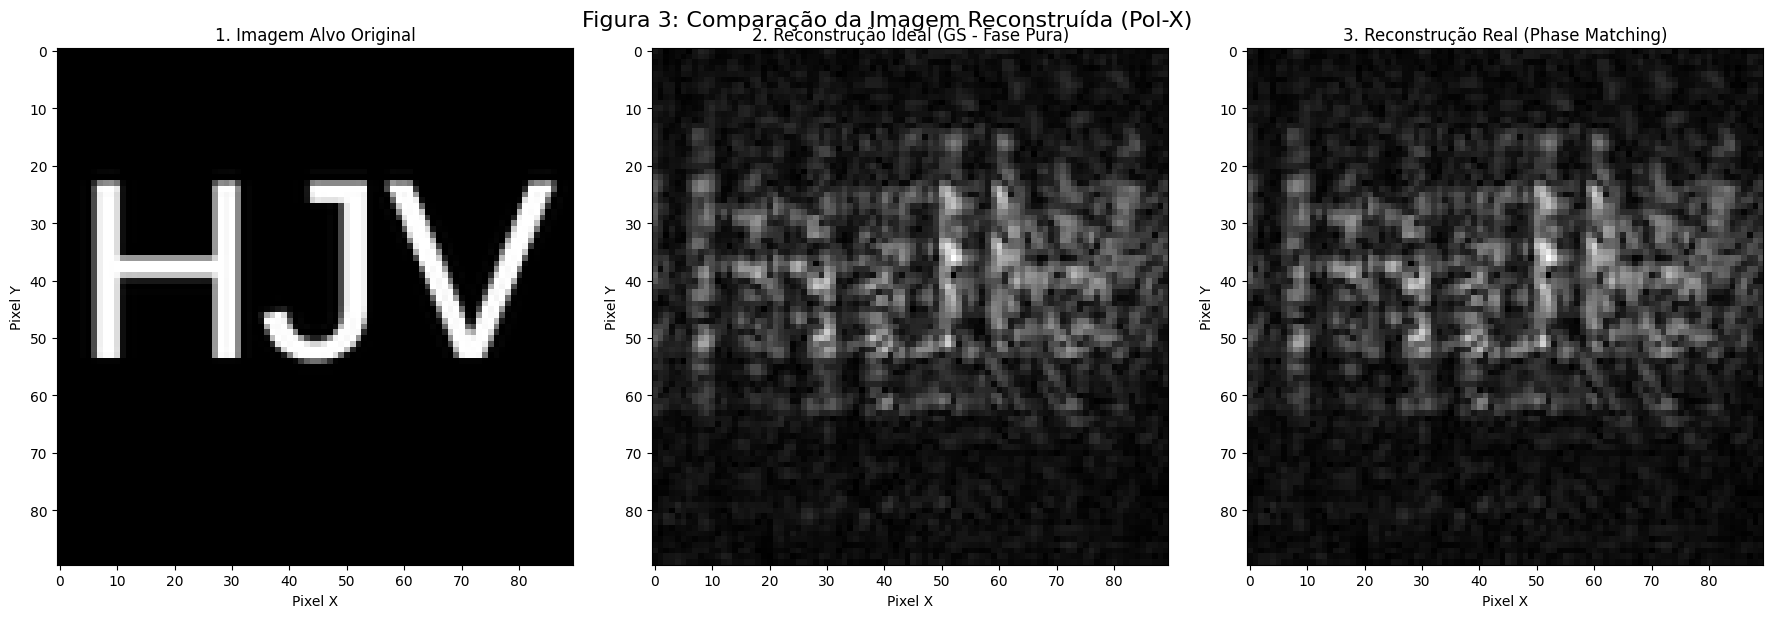

Gráfico 'comparacao_reconstrucao.png' salvo.
Gerando e salvando gráficos de resultados...


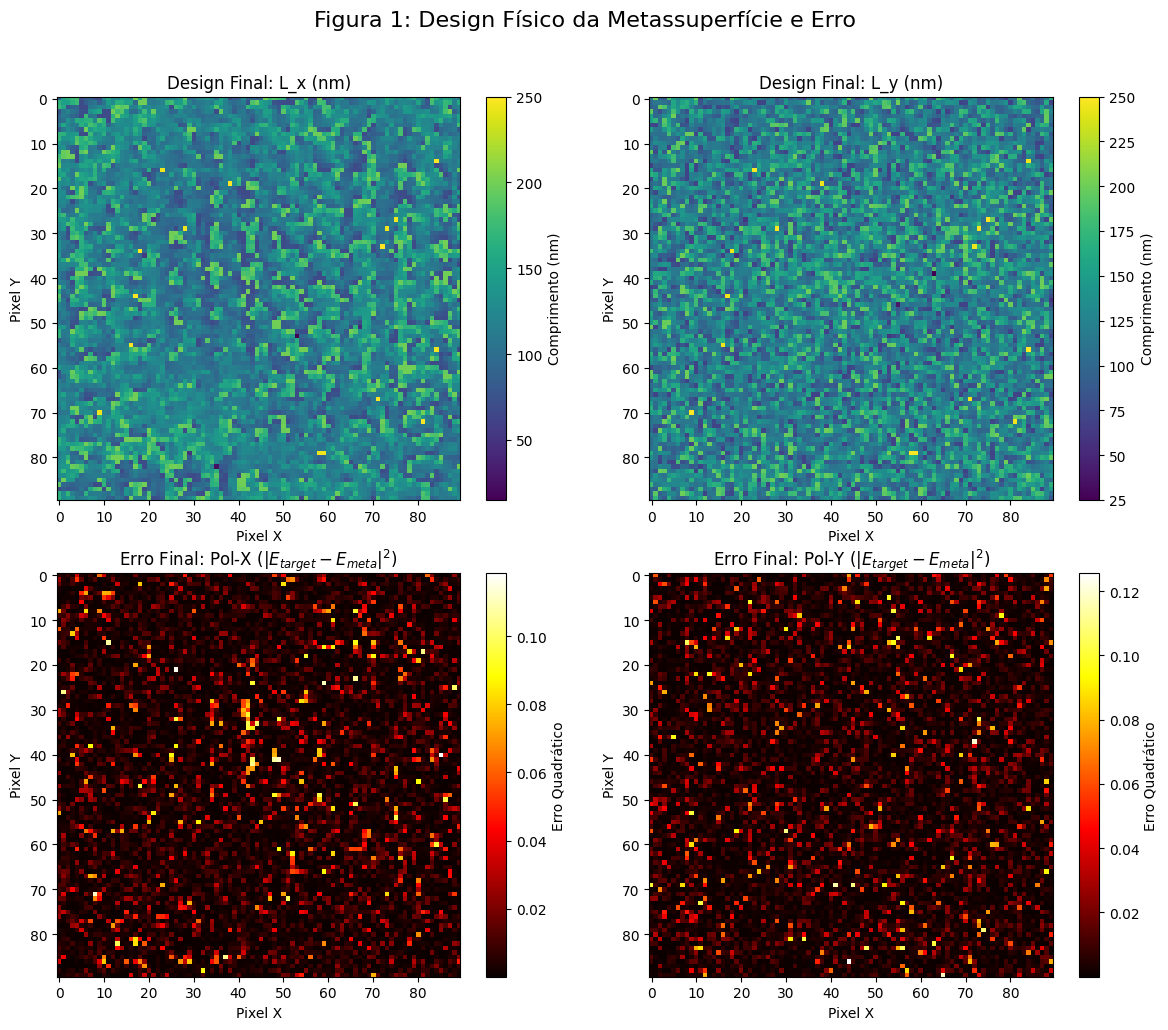

Gráfico 'design_fisico_e_erro.png' salvo.


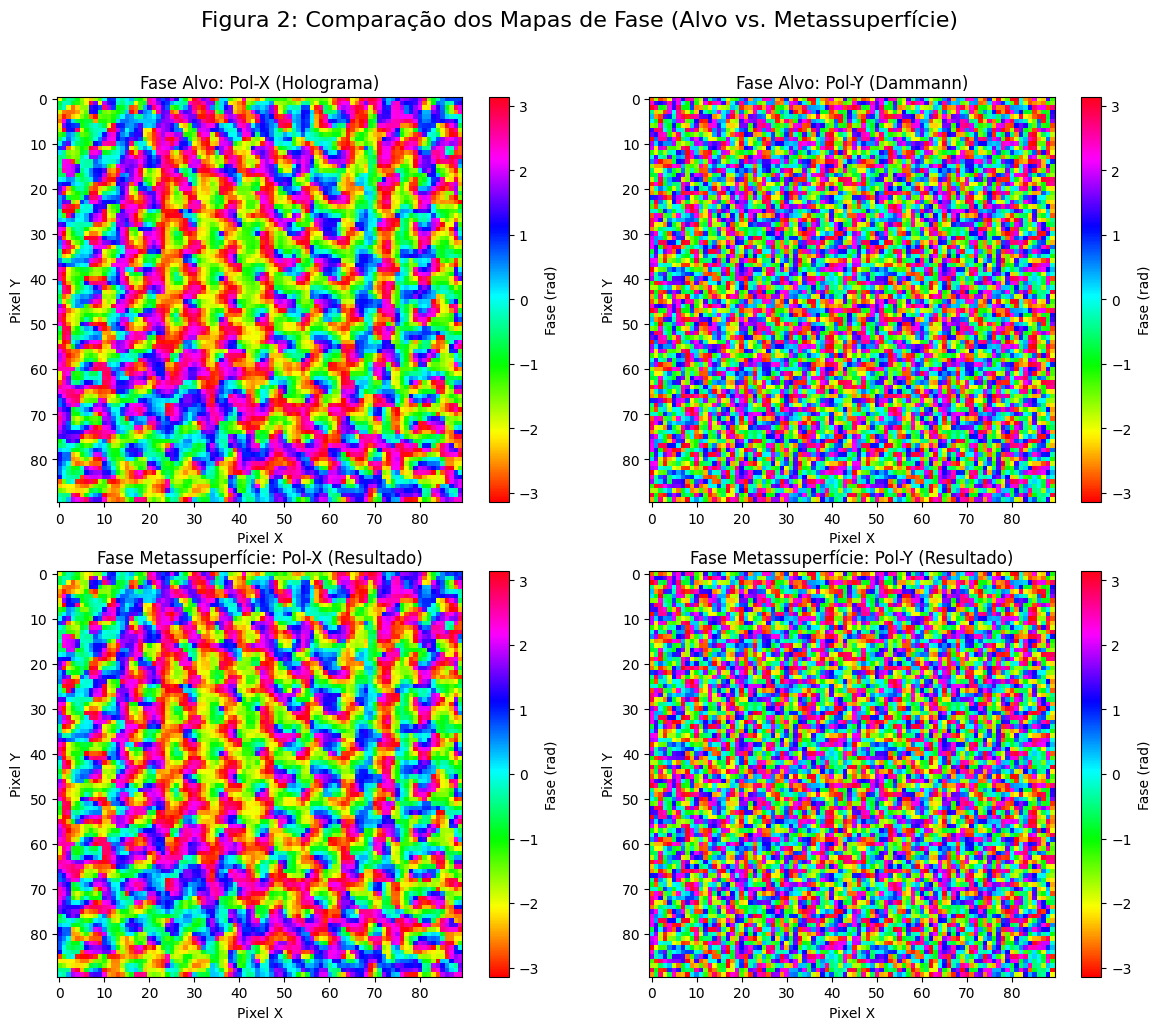

Gráfico 'comparacao_fase_alvo_vs_meta.png' salvo.
Calculando erro total e gerando histograma do Phase Matching...


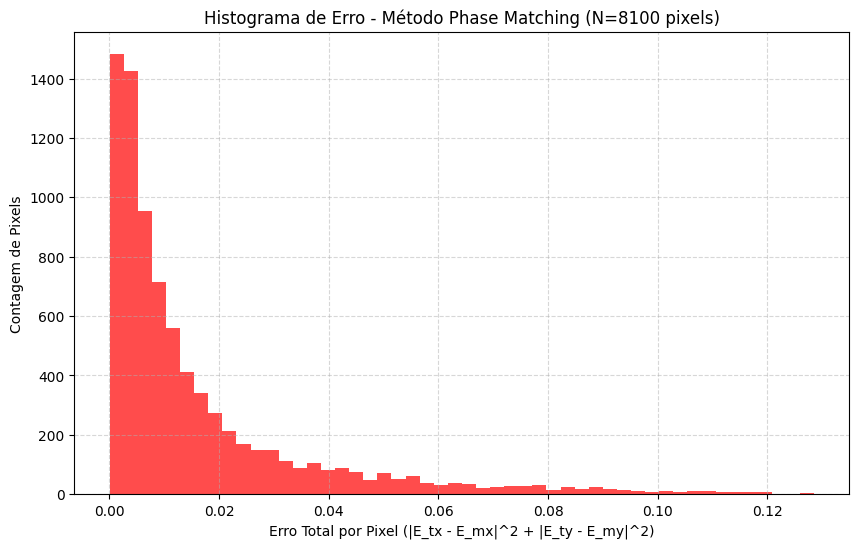

Histograma do Phase Matching salvo.


In [20]:
# --- ADICIONE ESTE BLOCO NO FINAL DO SCRIPT, ANTES DOS PLOTS ---

print("\nReconstruindo imagem final a partir do campo da metassuperfície (Phase Matching)...")

# Criar o campo complexo para Pol-X (Holograma)
# Usamos a amplitude E a fase resultantes do Phase Matching
campo_complexo_x_final = mapa_amp_x_final * np.exp(1j * mapa_fase_x_final)

# Usar os mesmos parâmetros do GS (wavelength, z, dx, NA)
# (Essas variáveis já existem da seção GS)
img_reconstruida_final_pm = reconstruct_image_from_field(
    campo_complexo_x_final,
    wavelength,
    z,
    dx,
    NA
)
print("Reconstrução final (PM) concluída.")


print("Gerando gráfico de comparação de reconstrução...")

# 'img_original' e 'img_reconstruida' vêm da seção GS
# 'img_reconstruida_final_pm' é a que acabamos de criar

fig3 = plt.figure(figsize=(18, 6))
plt.suptitle("Figura 3: Comparação da Imagem Reconstruída (Pol-X)", fontsize=16)

# Painel 1: Imagem Alvo Original
plt.subplot(1, 3, 1)
plt.imshow(img_original, cmap='gray')
plt.title("1. Imagem Alvo Original")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 2: Reconstrução Ideal (do GS, Fase Pura)
# Esta é a 'img_reconstruida' da seção GS
plt.subplot(1, 3, 2)
plt.imshow(img_reconstruida, cmap='gray')
plt.title("2. Reconstrução Ideal (GS - Fase Pura)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 3: Reconstrução Real (do Phase Matching)
plt.subplot(1, 3, 3)
plt.imshow(img_reconstruida_final_pm, cmap='gray')
plt.title("3. Reconstrução Real (Phase Matching)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
plt.savefig("comparacao_reconstrucao.png", dpi=300, bbox_inches='tight')
plt.show()
print("Gráfico 'comparacao_reconstrucao.png' salvo.")

# -----------------------------------------------------------------
# O resto do seu código de plot (Figura 1, Figura 2) continua abaixo
# -----------------------------------------------------------------

print("Gerando e salvando gráficos de resultados...")

# --- Figura 1: Design Físico e Mapa de Erro ---
fig1 = plt.figure(figsize=(12, 10))
plt.suptitle("Figura 1: Design Físico da Metassuperfície e Erro", fontsize=16, y=1.02)

# Painel 1: L_x
plt.subplot(2, 2, 1)
plt.imshow(mapa_Lx_final, cmap='viridis')
plt.title("Design Final: L_x (nm)")
plt.colorbar(label="Comprimento (nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 2: L_y
plt.subplot(2, 2, 2)
plt.imshow(mapa_Ly_final, cmap='viridis')
plt.title("Design Final: L_y (nm)")
plt.colorbar(label="Comprimento (nm)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 3: Erro X
plt.subplot(2, 2, 3)
plt.imshow(mapa_erro_x_final, cmap='hot')
plt.title("Erro Final: Pol-X ($|E_{target} - E_{meta}|^2$)")
plt.colorbar(label="Erro Quadrático")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 4: Erro Y
plt.subplot(2, 2, 4)
plt.imshow(mapa_erro_y_final, cmap='hot')
plt.title("Erro Final: Pol-Y ($|E_{target} - E_{meta}|^2$)")
plt.colorbar(label="Erro Quadrático")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
# Salva a figura 1
plt.savefig("design_fisico_e_erro.png", dpi=300, bbox_inches='tight')
plt.show()
print("Gráfico 'design_fisico_e_erro.png' salvo.")


# --- Figura 2: Comparação dos Mapas de Fase ---
fig2 = plt.figure(figsize=(12, 10))
plt.suptitle("Figura 2: Comparação dos Mapas de Fase (Alvo vs. Metassuperfície)", fontsize=16, y=1.02)

# Painel 1: Fase Alvo X
plt.subplot(2, 2, 1)
plt.imshow(mapa_de_fase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Alvo: Pol-X (Holograma)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 2: Fase Alvo Y
plt.subplot(2, 2, 2)
plt.imshow(full_phase, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Alvo: Pol-Y (Dammann)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 3: Fase Meta X
plt.subplot(2, 2, 3)
plt.imshow(mapa_fase_x_final, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Metassuperfície: Pol-X (Resultado)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

# Painel 4: Fase Meta Y
plt.subplot(2, 2, 4)
plt.imshow(mapa_fase_y_final, cmap='hsv', vmin=-np.pi, vmax=np.pi)
plt.title("Fase Metassuperfície: Pol-Y (Resultado)")
plt.colorbar(label="Fase (rad)")
plt.xlabel("Pixel X")
plt.ylabel("Pixel Y")

plt.tight_layout()
# Salva a figura 2
plt.savefig("comparacao_fase_alvo_vs_meta.png", dpi=300, bbox_inches='tight')
plt.show()
print("Gráfico 'comparacao_fase_alvo_vs_meta.png' salvo.")

# --- ADICIONAR ESTE BLOCO ---

print("Calculando erro total e gerando histograma do Phase Matching...")

# 1. Calcular o Erro Total (Erro X + Erro Y)
mapa_erro_total = mapa_erro_x_final + mapa_erro_y_final

# 2. Achatar o array 2D para 1D para o histograma
erros_pm_flat = mapa_erro_total.flatten()

# 3. Salvar os dados do erro para comparação posterior
np.save('pm_errors.npy', erros_pm_flat)

# 4. Gerar o histograma apenas do Phase Matching
plt.figure(figsize=(10, 6))
plt.hist(erros_pm_flat, bins=50, alpha=0.7, color='red')
plt.title(f'Histograma de Erro - Método Phase Matching (N={len(erros_pm_flat)} pixels)')
plt.xlabel('Erro Total por Pixel (|E_tx - E_mx|^2 + |E_ty - E_my|^2)')
plt.ylabel('Contagem de Pixels')
plt.grid(True, linestyle='--', alpha=0.5)
plt.savefig('histograma_PhaseMatching.png', dpi=150)
plt.show()

print("Histograma do Phase Matching salvo.")
# ----------------------------

In [21]:
# import numpy as np
# import matplotlib.pyplot as plt

# print("Carregando dados de erro...")
# try:
#     erros_ga = np.load('ga_errors.npy')
#     erros_pm = np.load('pm_errors.npy')
# except FileNotFoundError:
#     print("ERRO: Certifique-se de que os arquivos 'ga_errors.npy' e 'pm_errors.npy' estão no mesmo diretório.")
#     exit()

# print(f"Erros GA: {len(erros_ga)} pixels, Média: {np.mean(erros_ga):.4f}")
# print(f"Erros PM: {len(erros_pm)} pixels, Média: {np.mean(erros_pm):.4f}")

# # --- Plot de Comparação ---
# plt.figure(figsize=(12, 7))

# # Definir os 'bins' (faixas) com base no máximo dos dois
# max_erro = max(np.max(erros_ga), np.max(erros_pm))
# bins = np.linspace(0, max_erro, 60) # 60 faixas de 0 até o erro máximo

# # density=True normaliza o histograma (útil se o N de pixels for ligeiramente diferente)
# plt.hist(erros_ga, bins=bins, alpha=0.7, label='GA + Rede Neural', color='blue', density=True)
# plt.hist(erros_pm, bins=bins, alpha=0.7, label='Phase Matching (Biblioteca)', color='red', density=True)

# plt.title('Comparação dos Histogramas de Erro (GA vs. Phase Matching)')
# plt.xlabel('Erro Total por Pixel')
# plt.ylabel('Densidade de Probabilidade (pixels normalizados)')
# plt.legend()
# plt.grid(True, linestyle='--', alpha=0.5)

# # (Opcional) Limitar o eixo X se houver outliers extremos
# # plt.xlim(0, 1.0)

# plt.savefig('comparacao_histogramas.png', dpi=300)
# plt.show()